### Reconsstruction of experimental nanoparticles using the Deep Image Prior approach

*This notebook presents the reconstruction of experimental nanoparticles from degraded acquisitions. The data set consists of 2D projections from a degraded acquisitions between +/-60° with 2° tilt angle. We also perform the restoration for two more degraded scenarios where several more projections are removed :*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

#### The DIP formulation adapted to tomography consists of solving the following problem :

$$ \hat{\theta} = \underset{\theta}{\arg\min} \left\| P F_{\theta}(z) - y \right\|_2^2 $$

Where :
- $ F_{\theta} $ is the network and weights to optimized
- $ P $ is the forward operator (Radon transform)
- $ z $ is an input noise
- $ y $ are the acquired projections

*The method is applied to a 2D sinogram in order to reconstruct a 2D image.*

In [1]:
import sys
sys.path.insert(0, '../../Src')
from model import *
from radon import *
from dip import *
from utils import *

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import torch
from pathlib import Path

plt.gray()

dtype = torch.cuda.FloatTensor
DEVICE = 'cuda'

<Figure size 640x480 with 0 Axes>

#### Load the experimental nanoparticles sinogram to reconstruct with deep image prior

Only one sinogram is reconstructed at a time. The sinogram of interest to reconstruct is chosen with the **data_index** value (between 0 and 512) and the acquisition scenario is chosen with **ACQUISITION_CASE**.

In this scenario, no reference sinograms and reconstructions are available for visual comparison.

In [2]:
IDX = 159 
projections = imread('../../Data/Experimental/haadf_experimental_data.tif')
proj = projections[:,IDX,:]
sinogram = torch.from_numpy(proj).type(dtype)

THETA = np.arange(27., 151., 2.)
IMG_SIZE = sinogram.shape[1]

# 1, 2 or 3 corresponding to acquisition range -60:2:+60, -60:10:+60 and -30:2:+30 respectively
ACQUISITION_CASE = 2
SELECT = {
    1: [sinogram, THETA],
    2: [sinogram[::5,:], THETA[::5]],
    3: [sinogram[15:-15,:], THETA[15:-15]],
}

degraded_sino = SELECT[ACQUISITION_CASE][0]
degraded_THETA = SELECT[ACQUISITION_CASE][1]

degraded_sirt = Radon2D(angle=np.deg2rad(degraded_THETA), size=IMG_SIZE).backward_sirt_ts(degraded_sino)

radon_op = Radon2D(angle=np.deg2rad(THETA), size=IMG_SIZE)
sirt_reco = radon_op.backward_sirt_ts(sinogram)

Text(0.5, 1.0, 'Degraded sinogram (missing projections) for on slice of the data')

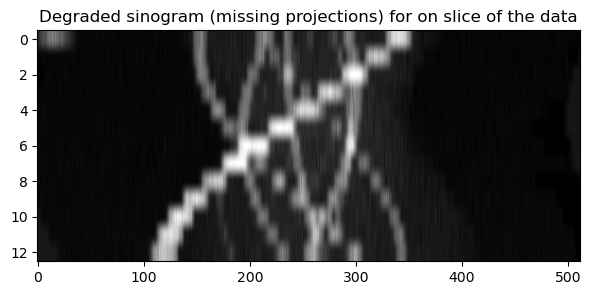

In [3]:
plt.figure(figsize = (7,3))
plt.imshow(simplify(degraded_sino), aspect='auto')
plt.title('Degraded sinogram (missing projections) for on slice of the data')

#### Setup of the network and DIP parameters

The parameters are set with the values from the article.

- *NUM_ITER* : Number of training iterations (empirical choice)
- *LR* : optimization learning rate
- *INPUT_DEPTH* : Depth size of the input noise
- *STD_INP_NOISE* : Range of the input noise
- *NOISE_REG* : Per iteration regularization value on the input noise (from original DIP implementation (D. Ulyanov et al.))

For the DIP method :
- A possible TV weight can be added to add a TV regularization (*TV_WEIGHT*)

In [4]:
NUM_ITER = 1500
LR = 0.01
INPUT_DEPTH = 32
STD_INP_NOISE = 1./10. 
NOISE_REG = 1./30.
TV_WEIGHT = 0.0 # Optionnal

In [5]:
n_scale = 4
ud_filters = [16,32,64,128]
skip_filters = [4,8,16,32]
network = model_unet(input_shape=INPUT_DEPTH, output_shape=1,
                     down_filters=ud_filters, up_filters=ud_filters, skip_filters=skip_filters,
                     down_kernels=[3]*n_scale, up_kernels=[3]*n_scale, skip_kernels=[1]*n_scale,
                     up_mode='bilinear', down_mode='stride', pad_mode='zeros',
                     ).to('cuda').type(dtype)

  0%|          | 0/1500 [00:00<?, ?it/s]/nobackup/sb272614/Environments/env_tomo/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([13, 512])) that is different to the input size (torch.Size([1, 1, 13, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


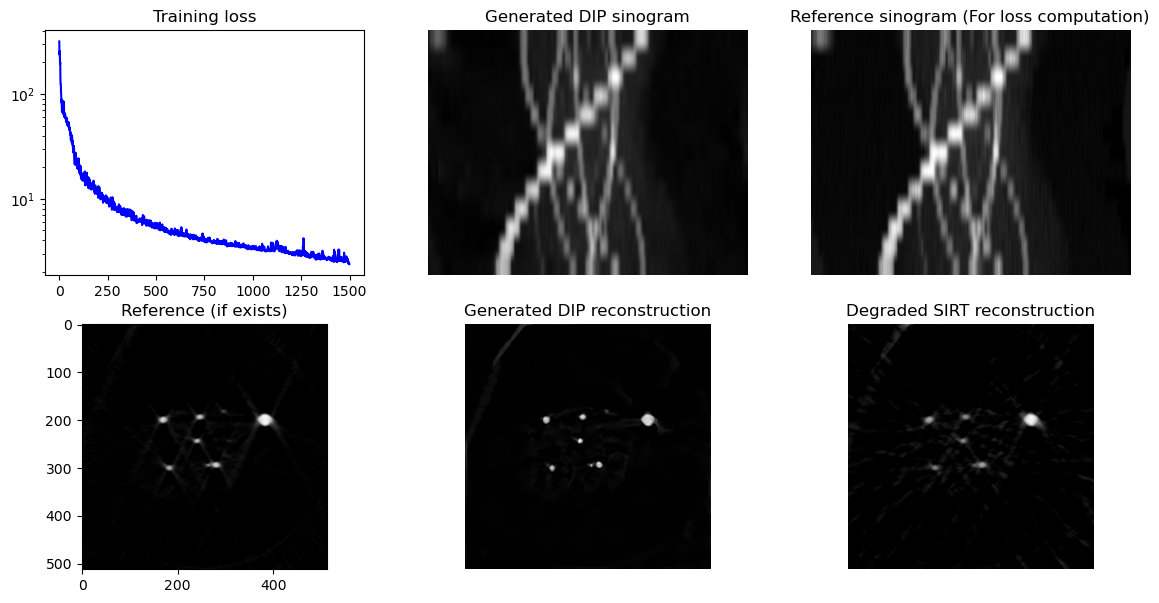

100%|██████████| 1500/1500 [02:09<00:00, 11.61it/s]


In [6]:
output = dip_reconstruction(NUM_ITER, LR, IMG_SIZE, STD_INP_NOISE, NOISE_REG,
                            np.flip(degraded_THETA), INPUT_DEPTH,
                            degraded_sino, degraded_sirt, sirt_reco, network, DISPLAY=True,
                            tv_weight=0.0, tv_order=1)

best_loss   = output['best_loss']
best_output = normalize(output['best_output'])
best_i      = output['best_i']
loss_values = output['loss_values']
net_trained = output['net']
best_input  = output['best_input']